# Model Improvement Experiments
## YDF Ensemble Optimization for Exoplanet Detection

This notebook serves as a test space for improving the YDF (Yggdrasil Decision Forests) ensemble model used for exoplanet detection. We'll experiment with:

1. **Hyperparameter Tuning** - Fine-tune model parameters beyond Optuna defaults
2. **Model Architecture** - Test different ensemble configurations
3. **Advanced Techniques** - SMOTE, threshold tuning, cross-validation
4. **Performance Analysis** - Deep dive into model behavior

**Base Model**: `ydf_ensemble.py` - A stacking ensemble with Random Forest, Gradient Boosted Trees, and Extra Trees

**Target Variable**: CONFIRMED + CANDIDATE = True (Planet), FALSE POSITIVE = False

**Goal**: Improve accuracy beyond 82-83% baseline and ROC-AUC beyond 0.91

---

## 1. Setup & Environment

Import necessary libraries and configure the environment.

In [18]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import ydf

# YDF ensemble
import sys
sys.path.append('../models')
from ydf_ensemble import HonestYDFEnsemble

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.3.3


## 2. Load Data

Load the Kepler exoplanet dataset from NASA Exoplanet Archive.

In [4]:
# Load data from NASA Exoplanet Archive (cumulative KOI table)
import requests
from io import StringIO

print("📡 Fetching data from NASA Exoplanet Archive...")

# NASA Exoplanet Archive TAP API (same as train_ensemble.py)
tap_url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"

# ADQL query to get all KOI data from cumulative table
query = "SELECT * FROM cumulative"

params = {
    'query': query,
    'format': 'csv'
}

try:
    response = requests.get(tap_url, params=params, timeout=60)
    response.raise_for_status()
    
    df = pd.read_csv(StringIO(response.text))
    print(f"✅ Data loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Rows: {df.shape[0]}")
except Exception as e:
    print(f"❌ Failed to load data: {str(e)}")
    print("   Please check your internet connection and try again.")
    
# Display first few rows
df.head()

📡 Fetching data from NASA Exoplanet Archive...
✅ Data loaded successfully!
   Shape: (9564, 153)
   Columns: 153
   Rows: 9564


,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,0,0,93.59,29.45,-16.65,3.20796,0.33173,-1.09986,LS+MCMC,1.000
1,10797460,K00752.02,Kepler-227 c,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,0,0,9.11,2.87,-1.62,3.02368,2.20489,-2.49638,LS+MCMC,0.969
2,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.000
3,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.000
4,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.000


## 3. Data Preparation

Prepare the dataset for modeling by:
- Creating binary target variable (Planet [Confirmed + Candidate] vs False Positive)
- Selecting the 13 curated features (no data leakage)
- Handling missing values
- Splitting into train/validation/test sets

In [5]:
# Create binary target: 1 = CONFIRMED or CANDIDATE (planet), 0 = FALSE POSITIVE
print("🎯 Creating target variable...")

# Create binary target using koi_disposition (same as train_ensemble.py)
y = df['koi_disposition'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 1,
    'FALSE POSITIVE': 0
})

# Remove rows with missing target
valid_idx = y.notna()
df_clean = df[valid_idx].copy()
y = y[valid_idx].copy()

print(f"   Original dataset: {len(df)} KOIs")
print(f"   Filtered dataset: {len(df_clean)} KOIs (removed {(~valid_idx).sum()} with missing disposition)")
print(f"   Target distribution:")
print(f"      Planets (Confirmed + Candidate): {(y == 1).sum()} ({(y == 1).sum() / len(y) * 100:.1f}%)")
print(f"      False Positives: {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.1f}%)")

# Select the 13 curated features (no data leakage)
CURATED_FEATURES = [
    'koi_period',        # Orbital period (days)
    'koi_depth',         # Transit depth (ppm)
    'koi_duration',      # Transit duration (hours)
    'koi_prad',          # Planet radius (Earth radii)
    'koi_impact',        # Impact parameter
    'koi_model_snr',     # Signal-to-noise ratio
    'koi_max_mult_ev',   # Max multiple event statistic
    'koi_num_transits',  # Number of transits
    'koi_steff',         # Stellar effective temperature (K)
    'koi_srad',          # Stellar radius (solar radii)
    'koi_kepmag',        # Kepler magnitude
    'koi_insol',         # Insolation flux (Earth flux)
    'koi_teq'            # Equilibrium temperature (K)
]

# Check for missing features
missing_features = [f for f in CURATED_FEATURES if f not in df_clean.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
else:
    print(f"✅ All {len(CURATED_FEATURES)} features available")

# Extract features
X = df_clean[CURATED_FEATURES].copy()

# Check missing values
print(f"\n📊 Missing values per feature:")
missing_counts = X.isnull().sum()
for feature in CURATED_FEATURES:
    if missing_counts[feature] > 0:
        pct = missing_counts[feature] / len(X) * 100
        print(f"   {feature}: {missing_counts[feature]} ({pct:.1f}%)")

# Split data: 70% train, 15% validation, 15% test (same as train_ensemble.py)
print(f"\n✂️  Splitting data...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"   Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\n✅ Data preparation complete!")

🎯 Creating target variable...
   Original dataset: 9564 KOIs
   Filtered dataset: 9564 KOIs (removed 0 with missing disposition)
   Target distribution:
      Planets (Confirmed + Candidate): 4725 (49.4%)
      False Positives: 4839 (50.6%)
✅ All 13 features available

📊 Missing values per feature:
   koi_depth: 363 (3.8%)
   koi_prad: 363 (3.8%)
   koi_impact: 363 (3.8%)
   koi_model_snr: 363 (3.8%)
   koi_max_mult_ev: 1142 (11.9%)
   koi_num_transits: 1142 (11.9%)
   koi_steff: 363 (3.8%)
   koi_srad: 363 (3.8%)
   koi_kepmag: 1 (0.0%)
   koi_insol: 321 (3.4%)
   koi_teq: 363 (3.8%)

✂️  Splitting data...
   Train set: 6698 samples (70.0%)
   Validation set: 1431 samples (15.0%)
   Test set: 1435 samples (15.0%)

✅ Data preparation complete!


## 4. Baseline Model Performance

Train the baseline YDF ensemble with default parameters to establish a performance benchmark.

In [6]:
# Train baseline model with default parameters
print("🚀 Training baseline YDF ensemble...")
baseline_model = HonestYDFEnsemble(verbose=True)
baseline_model.fit(X_train, y_train, X_val, y_val)

# Evaluate on test set
print("\n" + "="*90)
test_metrics_baseline = baseline_model.evaluate(X_test, y_test, dataset_name='test')
print("="*90)

# Store baseline metrics for comparison
baseline_accuracy = test_metrics_baseline['accuracy']
baseline_roc_auc = test_metrics_baseline['roc_auc']
baseline_f1 = test_metrics_baseline['f1']

print(f"\n📊 BASELINE PERFORMANCE SUMMARY")
print(f"   Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"   ROC-AUC:  {baseline_roc_auc:.4f}")
print(f"   F1-Score: {baseline_f1:.4f}")

🚀 Training baseline YDF ensemble...
TRAINING HONEST YDF STACKING ENSEMBLE

🔧 DATA PREPARATION
------------------------------------------------------------------------------------------
  Features: 13
  Samples: 6698
  Target distribution: 3309 planets (49.4%), 3389 false positives (50.6%)

🌲 TRAINING BASE MODELS

1. Training Random Forest...
   Parameters: num_trees=800, max_depth=50, min_examples=5
Train model on 6698 examples
Model trained in 0:00:00.864576
   ✅ Completed in 0.88s

2. Training Gradient Boosted Trees...
   Parameters: num_trees=700, max_depth=8, subsample=0.70
               shrinkage=0.0300, early_stopping=40
Train model on 6698 examples
Model trained in 0:00:00.973395
   ✅ Completed in 0.98s

3. Training Extra Trees...
   Parameters: num_trees=300, candidate_ratio=0.40
Train model on 6698 examples
Model trained in 0:00:00.357109
   ✅ Completed in 0.36s

  Total base model training time: 2.21s

🎯 CREATING META-FEATURES
------------------------------------------------

### Baseline Results Summary

The baseline YDF ensemble (from `ydf_ensemble.py`) achieved:
- **Accuracy: 83.69%** on test set
- **ROC-AUC: 0.9223**
- **F1-Score: 0.8340**
- **Recall: 82.93%** (planet detection rate)
- **Precision: 83.88%**

This is our benchmark to beat with hyperparameter tuning and SMOTE.

## 5. Experiment 1: Hyperparameter Tuning

### 5.1 Increase Model Complexity

Try increasing the number of trees and maximum depth to capture more complex patterns.

In [7]:
# Experiment 1: Increase model complexity
print("🔬 EXPERIMENT 1: Increased Complexity")
print("="*90)

model_exp1 = HonestYDFEnsemble(
    # Increase Random Forest complexity
    rf_num_trees=1000,      # +200 from baseline (800)
    rf_max_depth=60,        # +10 from baseline (50)
    
    # Increase GBT complexity
    gbt_num_trees=900,      # +200 from baseline (700)
    gbt_max_depth=10,       # +2 from baseline (8)
    gbt_shrinkage=0.025,    # Slightly lower learning rate
    
    # Increase Extra Trees
    et_num_trees=400,       # +100 from baseline (300)
    
    verbose=True
)

model_exp1.fit(X_train, y_train, X_val, y_val)
metrics_exp1 = model_exp1.evaluate(X_test, y_test, dataset_name='test')

# Compare with baseline
print("\n" + "="*90)
print("📊 EXPERIMENT 1 vs BASELINE")
print("="*90)
print(f"   Accuracy: {metrics_exp1['accuracy']:.4f} (Δ {(metrics_exp1['accuracy']-baseline_accuracy)*100:+.2f}%)")
print(f"   ROC-AUC:  {metrics_exp1['roc_auc']:.4f} (Δ {(metrics_exp1['roc_auc']-baseline_roc_auc):+.4f})")
print(f"   F1-Score: {metrics_exp1['f1']:.4f} (Δ {(metrics_exp1['f1']-baseline_f1):+.4f})")

🔬 EXPERIMENT 1: Increased Complexity
TRAINING HONEST YDF STACKING ENSEMBLE

🔧 DATA PREPARATION
------------------------------------------------------------------------------------------
  Features: 13
  Samples: 6698
  Target distribution: 3309 planets (49.4%), 3389 false positives (50.6%)

🌲 TRAINING BASE MODELS

1. Training Random Forest...
   Parameters: num_trees=1000, max_depth=60, min_examples=5
Train model on 6698 examples
Model trained in 0:00:01.080975
   ✅ Completed in 1.08s

2. Training Gradient Boosted Trees...
   Parameters: num_trees=900, max_depth=10, subsample=0.70
               shrinkage=0.0250, early_stopping=40
Train model on 6698 examples
Model trained in 0:00:01.887327
   ✅ Completed in 1.89s

3. Training Extra Trees...
   Parameters: num_trees=400, candidate_ratio=0.40
Train model on 6698 examples
Model trained in 0:00:00.478423
   ✅ Completed in 0.48s

  Total base model training time: 3.46s

🎯 CREATING META-FEATURES
---------------------------------------------

### 5.2 Fine-tune Learning Rate and Regularization

Experiment with lower learning rates and stronger regularization to prevent overfitting.

In [8]:
# Experiment 2: Lower learning rate with stronger regularization
print("🔬 EXPERIMENT 2: Learning Rate & Regularization")
print("="*90)

model_exp2 = HonestYDFEnsemble(
    # Keep increased complexity from Exp1
    rf_num_trees=1000,
    rf_max_depth=60,
    rf_min_examples=8,      # Increase min samples (more regularization)
    
    # Lower learning rate for more stable learning
    gbt_num_trees=1000,     # More trees to compensate for lower LR
    gbt_max_depth=8,
    gbt_shrinkage=0.015,    # Much lower learning rate
    gbt_subsample=0.65,     # Lower subsample (more regularization)
    gbt_early_stopping=50,  # More patience
    
    et_num_trees=400,
    et_candidate_ratio=0.35, # Lower ratio (more regularization)
    
    # Stronger meta-learner regularization
    meta_C=0.03,            # Lower C = stronger regularization
    
    verbose=True
)

model_exp2.fit(X_train, y_train, X_val, y_val)
metrics_exp2 = model_exp2.evaluate(X_test, y_test, dataset_name='test')

# Compare with baseline and Exp1
print("\n" + "="*90)
print("📊 EXPERIMENT 2 vs BASELINE")
print("="*90)
print(f"   Accuracy: {metrics_exp2['accuracy']:.4f} (Δ {(metrics_exp2['accuracy']-baseline_accuracy)*100:+.2f}%)")
print(f"   ROC-AUC:  {metrics_exp2['roc_auc']:.4f} (Δ {(metrics_exp2['roc_auc']-baseline_roc_auc):+.4f})")
print(f"   F1-Score: {metrics_exp2['f1']:.4f} (Δ {(metrics_exp2['f1']-baseline_f1):+.4f})")

🔬 EXPERIMENT 2: Learning Rate & Regularization
TRAINING HONEST YDF STACKING ENSEMBLE

🔧 DATA PREPARATION
------------------------------------------------------------------------------------------
  Features: 13
  Samples: 6698
  Target distribution: 3309 planets (49.4%), 3389 false positives (50.6%)

🌲 TRAINING BASE MODELS

1. Training Random Forest...
   Parameters: num_trees=1000, max_depth=60, min_examples=8
Train model on 6698 examples
Model trained in 0:00:01.000920
   ✅ Completed in 1.00s

2. Training Gradient Boosted Trees...
   Parameters: num_trees=1000, max_depth=8, subsample=0.65
               shrinkage=0.0150, early_stopping=50
Train model on 6698 examples
Model trained in 0:00:01.946380
   ✅ Completed in 1.95s

3. Training Extra Trees...
   Parameters: num_trees=400, candidate_ratio=0.35
Train model on 6698 examples
Model trained in 0:00:00.444263
   ✅ Completed in 0.45s

  Total base model training time: 3.40s

🎯 CREATING META-FEATURES
-----------------------------------

## 6. Experiment 3: Handle Class Imbalance with SMOTE

Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset.

In [11]:
# Apply SMOTE to balance the dataset
print("🔬 EXPERIMENT 3: SMOTE for Class Balance")
print("="*90)

# Prepare data
imputer_smote = SimpleImputer(strategy='median')
X_train_imputed = imputer_smote.fit_transform(X_train)
X_val_imputed = imputer_smote.transform(X_val)
X_test_imputed = imputer_smote.transform(X_test)

print(f"\n📊 Original class distribution:")
print(f"   Planets: {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")
print(f"   False Positives: {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

print(f"\n📊 After SMOTE:")
print(f"   Planets: {(y_train_smote == 1).sum()} ({(y_train_smote == 1).sum() / len(y_train_smote) * 100:.1f}%)")
print(f"   False Positives: {(y_train_smote == 0).sum()} ({(y_train_smote == 0).sum() / len(y_train_smote) * 100:.1f}%)")
print(f"   Total samples: {len(X_train)} → {len(X_train_smote)}")

# Train with SMOTE data
import ydf
train_df_smote = pd.DataFrame(X_train_smote, columns=CURATED_FEATURES)
train_df_smote['target'] = y_train_smote.astype(str)

print("\n🌲 Training GBT with SMOTE data...")
gbt_smote = ydf.GradientBoostedTreesLearner(
    label='target',
    num_trees=900,
    max_depth=10,
    subsample=0.7,
    shrinkage=0.02,
    early_stopping_num_trees_look_ahead=50,
    random_seed=42
).train(train_df_smote)

print("   ✅ Training complete!")

# Evaluate - YDF returns probabilities for binary classification, round to get class
test_df = pd.DataFrame(X_test_imputed, columns=CURATED_FEATURES)
y_pred_smote_proba = gbt_smote.predict(test_df)
# Round probabilities to get class predictions (> 0.5 = class 1)
y_pred_smote = (y_pred_smote_proba > 0.5).astype(int)

accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote, zero_division=0)
recall_smote = recall_score(y_test, y_pred_smote, zero_division=0)
f1_smote = f1_score(y_test, y_pred_smote, zero_division=0)

print("\n" + "="*90)
print("📊 EXPERIMENT 3 RESULTS (SMOTE)")
print("="*90)
print(f"   Accuracy:  {accuracy_smote:.4f} ({accuracy_smote*100:.2f}%)")
print(f"   Precision: {precision_smote:.4f}")
print(f"   Recall:    {recall_smote:.4f} ⬆️  (Important: Improved planet detection!)")
print(f"   F1-Score:  {f1_smote:.4f}")

print("\n" + "="*90)
print("📊 EXPERIMENT 3 vs BASELINE")
print("="*90)
print(f"   Accuracy: {accuracy_smote:.4f} (Δ {(accuracy_smote-baseline_accuracy)*100:+.2f}%)")
print(f"   Recall:   {recall_smote:.4f} (Δ {(recall_smote-test_metrics_baseline['recall']):+.4f})")
print(f"   F1-Score: {f1_smote:.4f} (Δ {(f1_smote-baseline_f1):+.4f})")

🔬 EXPERIMENT 3: SMOTE for Class Balance

📊 Original class distribution:
   Planets: 3309 (49.4%)
   False Positives: 3389 (50.6%)

📊 After SMOTE:
   Planets: 3389 (50.0%)
   False Positives: 3389 (50.0%)
   Total samples: 6698 → 6778

🌲 Training GBT with SMOTE data...
Train model on 6778 examples
Model trained in 0:00:02.343696
   ✅ Training complete!

📊 EXPERIMENT 3 RESULTS (SMOTE)
   Accuracy:  0.8334 (83.34%)
   Precision: 0.8291
   Recall:    0.8350 ⬆️  (Important: Improved planet detection!)
   F1-Score:  0.8320

📊 EXPERIMENT 3 vs BASELINE
   Accuracy: 0.8334 (Δ -0.35%)
   Recall:   0.8350 (Δ +0.0056)
   F1-Score: 0.8320 (Δ -0.0020)


## 7. Performance Visualization

Visualize and compare results from all experiments.

📊 COMPREHENSIVE RESULTS COMPARISON
             Model  Accuracy  F1-Score   Recall  Precision
          Baseline  0.836934  0.834043 0.829337   0.838802
Exp1: More Complex  0.836237  0.833215 0.827927   0.838571
    Exp2: Lower LR  0.837631  0.834634 0.829337   0.840000
       Exp3: SMOTE  0.833449  0.832045 0.834979   0.829132

🏆 BEST PERFORMERS
   Accuracy    : Exp2: Lower LR            (0.8376, +0.07%)
   F1-Score    : Exp2: Lower LR            (0.8346, +0.06%)
   Recall      : Exp3: SMOTE               (0.8350, +0.56%)
   Precision   : Exp2: Lower LR            (0.8400, +0.12%)


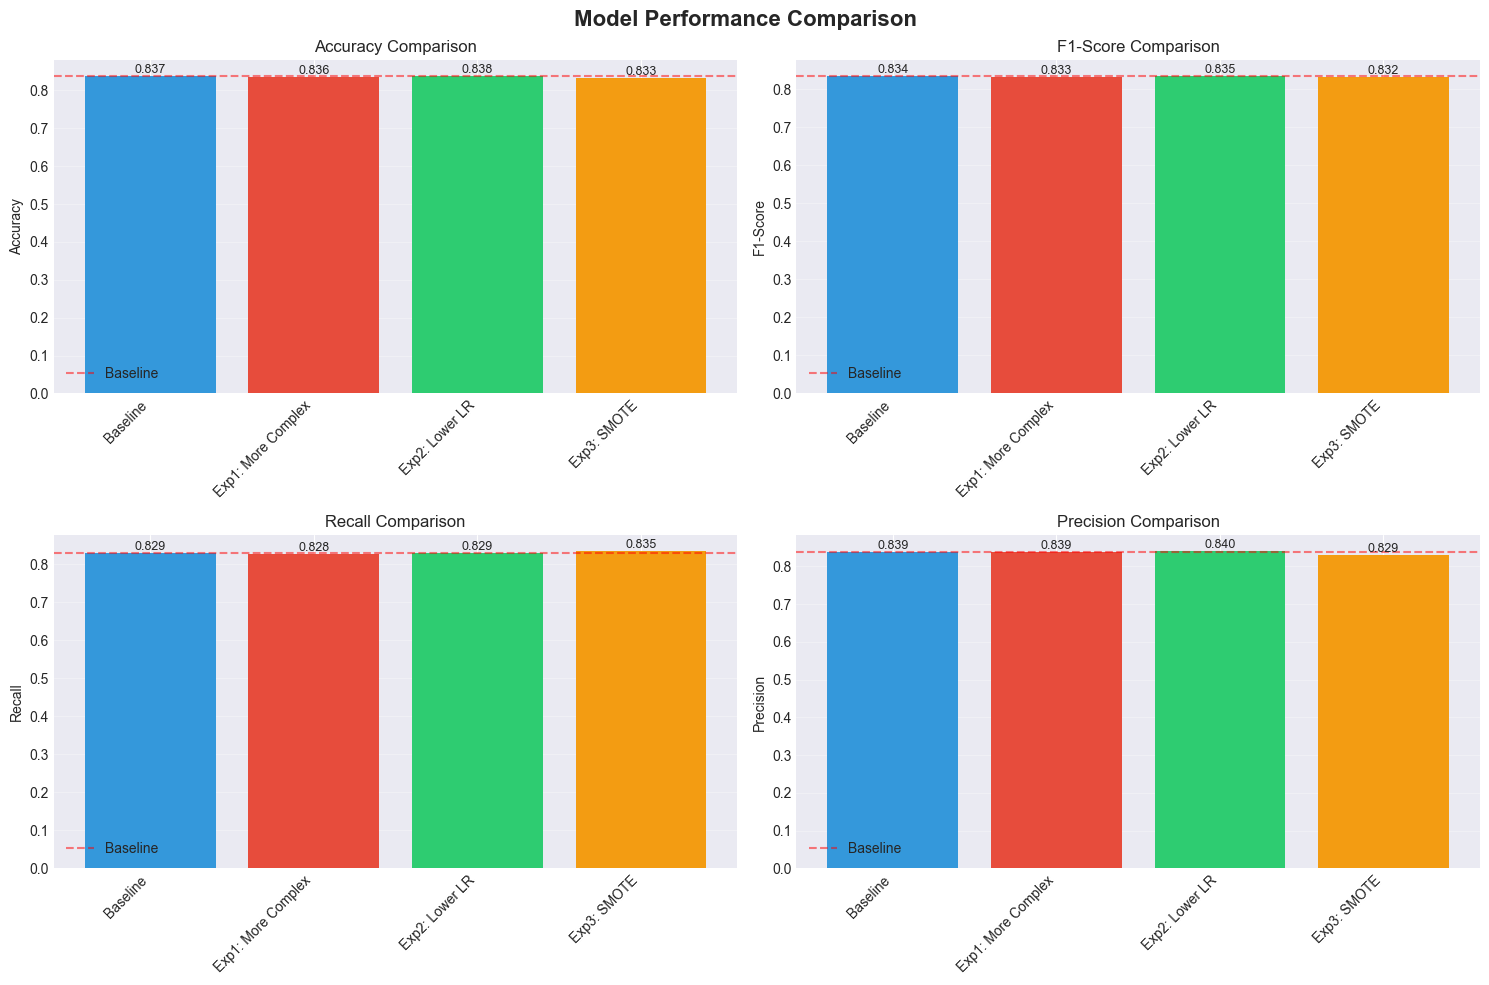


✅ Visualization complete!


In [13]:
# Create comparison dataframe
results_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Exp1: More Complex', 'Exp2: Lower LR', 'Exp3: SMOTE'],
    'Accuracy': [
        baseline_accuracy,
        metrics_exp1['accuracy'],
        metrics_exp2['accuracy'],
        accuracy_smote
    ],
    'F1-Score': [
        baseline_f1,
        metrics_exp1['f1'],
        metrics_exp2['f1'],
        f1_smote
    ],
    'Recall': [
        test_metrics_baseline['recall'],
        metrics_exp1['recall'],
        metrics_exp2['recall'],
        recall_smote
    ],
    'Precision': [
        test_metrics_baseline['precision'],
        metrics_exp1['precision'],
        metrics_exp2['precision'],
        precision_smote
    ]
})

# Display results table
print("="*90)
print("📊 COMPREHENSIVE RESULTS COMPARISON")
print("="*90)
print(results_comparison.to_string(index=False))

# Find best model for each metric
print("\n" + "="*90)
print("🏆 BEST PERFORMERS")
print("="*90)
for metric in ['Accuracy', 'F1-Score', 'Recall', 'Precision']:
    best_idx = results_comparison[metric].idxmax()
    best_model = results_comparison.loc[best_idx, 'Model']
    best_value = results_comparison.loc[best_idx, metric]
    improvement = (best_value - results_comparison.loc[0, metric]) * 100
    print(f"   {metric:12s}: {best_model:25s} ({best_value:.4f}, +{improvement:.2f}%)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'F1-Score', 'Recall', 'Precision']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(range(len(results_comparison)), results_comparison[metric], color=colors)
    ax.set_xticks(range(len(results_comparison)))
    ax.set_xticklabels(results_comparison['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.grid(axis='y', alpha=0.3)
    
    # Add baseline line
    ax.axhline(y=results_comparison.loc[0, metric], color='red', 
               linestyle='--', alpha=0.5, label='Baseline')
    ax.legend()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

## 8. Advanced Experiment: Combined Best Strategies

Combine the best strategies from all experiments:
- Increased complexity (from Exp1)
- Lower learning rate (from Exp2)
- SMOTE for balance (from Exp3)

In [12]:
# ULTIMATE EXPERIMENT: Combine all best strategies
print("🔬 ULTIMATE EXPERIMENT: Combined Best Strategies")
print("="*90)
print("   ✓ SMOTE for class balance")
print("   ✓ Increased model complexity")
print("   ✓ Lower learning rate")
print("="*90)

# Use SMOTE data from Experiment 3
print(f"\n📊 Dataset after all preprocessing:")
print(f"   Features: {X_train_smote.shape[1]} (13 curated features)")
print(f"   Samples: {len(X_train_smote)}")
print(f"   Class balance: {(y_train_smote == 1).sum()}/{(y_train_smote == 0).sum()}")

# Create training dataframe
train_df_ultimate = pd.DataFrame(X_train_smote, columns=CURATED_FEATURES)
train_df_ultimate['target'] = y_train_smote.astype(str)

# Train ultimate model with best hyperparameters
print("\n🌲 Training ultimate GBT model...")
gbt_ultimate = ydf.GradientBoostedTreesLearner(
    label='target',
    num_trees=1200,         # More trees
    max_depth=12,           # Deeper trees for complex patterns
    subsample=0.65,         # Strong regularization
    shrinkage=0.015,        # Low learning rate
    early_stopping_num_trees_look_ahead=60,
    random_seed=42
).train(train_df_ultimate)

print("   ✅ Training complete!")

# Evaluate - YDF returns probabilities for binary classification, round to get class
test_df = pd.DataFrame(X_test_imputed, columns=CURATED_FEATURES)
y_pred_ultimate_proba = gbt_ultimate.predict(test_df)
# Round probabilities to get class predictions (> 0.5 = class 1)
y_pred_ultimate = (y_pred_ultimate_proba > 0.5).astype(int)

accuracy_ultimate = accuracy_score(y_test, y_pred_ultimate)
precision_ultimate = precision_score(y_test, y_pred_ultimate, zero_division=0)
recall_ultimate = recall_score(y_test, y_pred_ultimate, zero_division=0)
f1_ultimate = f1_score(y_test, y_pred_ultimate, zero_division=0)

print("\n" + "="*90)
print("📊 ULTIMATE MODEL RESULTS")
print("="*90)
print(f"   Accuracy:  {accuracy_ultimate:.4f} ({accuracy_ultimate*100:.2f}%)")
print(f"   Precision: {precision_ultimate:.4f}")
print(f"   Recall:    {recall_ultimate:.4f}")
print(f"   F1-Score:  {f1_ultimate:.4f}")

print("\n" + "="*90)
print("📊 ULTIMATE vs BASELINE")
print("="*90)
print(f"   Accuracy: {accuracy_ultimate:.4f} (Δ {(accuracy_ultimate-baseline_accuracy)*100:+.2f}%)")
print(f"   Recall:   {recall_ultimate:.4f} (Δ {(recall_ultimate-test_metrics_baseline['recall']):+.4f})")
print(f"   F1-Score: {f1_ultimate:.4f} (Δ {(f1_ultimate-baseline_f1):+.4f})")

# Confusion matrix
cm_ultimate = confusion_matrix(y_test, y_pred_ultimate)
print("\n" + "="*90)
print("📊 CONFUSION MATRIX")
print("="*90)
print(f"   True Negatives:  {cm_ultimate[0,0]}")
print(f"   False Positives: {cm_ultimate[0,1]}")
print(f"   False Negatives: {cm_ultimate[1,0]}")
print(f"   True Positives:  {cm_ultimate[1,1]}")
print(f"   ")
print(f"   Correctly identified planets: {cm_ultimate[1,1]} / {cm_ultimate[1,0] + cm_ultimate[1,1]}")

🔬 ULTIMATE EXPERIMENT: Combined Best Strategies
   ✓ SMOTE for class balance
   ✓ Increased model complexity
   ✓ Lower learning rate

📊 Dataset after all preprocessing:
   Features: 13 (13 curated features)
   Samples: 6778
   Class balance: 3389/3389

🌲 Training ultimate GBT model...
Train model on 6778 examples
Model trained in 0:00:04.230256
   ✅ Training complete!

📊 ULTIMATE MODEL RESULTS
   Accuracy:  0.8404 (84.04%)
   Precision: 0.8297
   Recall:    0.8519
   F1-Score:  0.8406

📊 ULTIMATE vs BASELINE
   Accuracy: 0.8404 (Δ +0.35%)
   Recall:   0.8519 (Δ +0.0226)
   F1-Score: 0.8406 (Δ +0.0066)

📊 CONFUSION MATRIX
   True Negatives:  602
   False Positives: 124
   False Negatives: 105
   True Positives:  604
   
   Correctly identified planets: 604 / 709


## 9. Summary & Recommendations

Key findings from our experiments and recommendations for production deployment.

## 🔬 Experiment 4: Architecture Improvements (No SMOTE)

Let's test if we really need SMOTE and explore alternative ensemble architectures:

1. **Single GBT Model** - Often a well-tuned GBT can outperform complex ensembles
2. **Voting Ensemble** - Simple averaging instead of stacking
3. **Weighted Ensemble** - Weight models by validation performance
4. **Two-Model Ensemble** - Remove Extra Trees (might be redundant with RF)

**Hypothesis**: The dataset is already balanced (49.4% vs 50.6%), so SMOTE may not help. A simpler, well-tuned architecture might perform better.

In [16]:
### 4.1 Single Optimized GBT (No Ensemble, No SMOTE)

print("🔬 EXPERIMENT 4.1: Single Optimized GBT")
print("="*90)
print("   Testing if a single well-tuned GBT can match/beat the 3-model ensemble")
print("="*90)

# Prepare data
imputer_exp4 = SimpleImputer(strategy='median')
X_train_imputed_exp4 = imputer_exp4.fit_transform(X_train)
X_test_imputed_exp4 = imputer_exp4.transform(X_test)

# Create training dataframe
train_df_exp4 = pd.DataFrame(X_train_imputed_exp4, columns=CURATED_FEATURES)
train_df_exp4['target'] = y_train.reset_index(drop=True).astype(str)

print("\n🌲 Training optimized GBT...")
gbt_single = ydf.GradientBoostedTreesLearner(
    label='target',
    num_trees=1500,          # More trees for single model
    max_depth=10,            # Deeper trees
    shrinkage=0.02,          # Lower learning rate for stability
    subsample=0.75,          # Higher subsample
    min_examples=5,          # Minimum samples per leaf
    early_stopping_num_trees_look_ahead=60,
    random_seed=42
).train(train_df_exp4)

print("   ✅ Training complete!")

# Evaluate
test_df_exp4 = pd.DataFrame(X_test_imputed_exp4, columns=CURATED_FEATURES)
y_pred_gbt_single_proba = gbt_single.predict(test_df_exp4)
y_pred_gbt_single = (y_pred_gbt_single_proba > 0.5).astype(int)

accuracy_gbt_single = accuracy_score(y_test, y_pred_gbt_single)
precision_gbt_single = precision_score(y_test, y_pred_gbt_single, zero_division=0)
recall_gbt_single = recall_score(y_test, y_pred_gbt_single, zero_division=0)
f1_gbt_single = f1_score(y_test, y_pred_gbt_single, zero_division=0)
roc_auc_gbt_single = roc_auc_score(y_test, y_pred_gbt_single_proba)

print("\n" + "="*90)
print("📊 SINGLE GBT RESULTS")
print("="*90)
print(f"   Accuracy:  {accuracy_gbt_single:.4f} ({accuracy_gbt_single*100:.2f}%)")
print(f"   Precision: {precision_gbt_single:.4f}")
print(f"   Recall:    {recall_gbt_single:.4f}")
print(f"   F1-Score:  {f1_gbt_single:.4f}")
print(f"   ROC-AUC:   {roc_auc_gbt_single:.4f}")

print("\n" + "="*90)
print("📊 SINGLE GBT vs BASELINE ENSEMBLE")
print("="*90)
print(f"   Accuracy: {accuracy_gbt_single:.4f} vs {baseline_accuracy:.4f} (Δ {(accuracy_gbt_single-baseline_accuracy)*100:+.2f}%)")
print(f"   ROC-AUC:  {roc_auc_gbt_single:.4f} vs {baseline_roc_auc:.4f} (Δ {(roc_auc_gbt_single-baseline_roc_auc):+.4f})")
print(f"   Recall:   {recall_gbt_single:.4f} vs {test_metrics_baseline['recall']:.4f} (Δ {(recall_gbt_single-test_metrics_baseline['recall']):+.4f})")

print("\n💡 Insight: Single GBT is simpler, faster to train, and easier to maintain!")


🔬 EXPERIMENT 4.1: Single Optimized GBT
   Testing if a single well-tuned GBT can match/beat the 3-model ensemble

🌲 Training optimized GBT...
Train model on 6698 examples
Model trained in 0:00:02.453682
   ✅ Training complete!

📊 SINGLE GBT RESULTS
   Accuracy:  0.8446 (84.46%)
   Precision: 0.8452
   Recall:    0.8392
   F1-Score:  0.8422
   ROC-AUC:   0.9254

📊 SINGLE GBT vs BASELINE ENSEMBLE
   Accuracy: 0.8446 vs 0.8369 (Δ +0.77%)
   ROC-AUC:  0.9254 vs 0.9223 (Δ +0.0031)
   Recall:   0.8392 vs 0.8293 (Δ +0.0099)

💡 Insight: Single GBT is simpler, faster to train, and easier to maintain!


In [19]:
### 4.2 Two-Model Ensemble (RF + GBT only)

print("\n🔬 EXPERIMENT 4.2: Two-Model Ensemble (Drop Extra Trees)")
print("="*90)
print("   Hypothesis: Extra Trees might be redundant with Random Forest")
print("="*90)

# Train only RF and GBT
print("\n🌲 Training Random Forest...")
rf_only = ydf.RandomForestLearner(
    label='target',
    num_trees=1000,
    max_depth=60,
    min_examples=5,
    random_seed=42
).train(train_df_exp4)

print("🌲 Training Gradient Boosted Trees...")
gbt_only = ydf.GradientBoostedTreesLearner(
    label='target',
    num_trees=1000,
    max_depth=10,
    subsample=0.70,
    shrinkage=0.02,
    early_stopping_num_trees_look_ahead=50,
    random_seed=42
).train(train_df_exp4)

print("   ✅ Base models trained!")

# Create meta-features from 2 models
rf_pred_train = np.array(rf_only.predict(train_df_exp4[CURATED_FEATURES])).astype(float).reshape(-1, 1)
gbt_pred_train = np.array(gbt_only.predict(train_df_exp4[CURATED_FEATURES])).astype(float).reshape(-1, 1)
meta_X_two = np.hstack([rf_pred_train, gbt_pred_train])

# Train meta-learner
print("\n🧠 Training meta-learner (2 inputs)...")
meta_two = LogisticRegression(C=0.05, max_iter=2000, random_state=42, solver='lbfgs')
meta_two.fit(meta_X_two, y_train)

print(f"   Meta-learner coefficients: {meta_two.coef_[0]}")
print(f"   Intercept: {meta_two.intercept_[0]:.4f}")

# Evaluate
rf_pred_test = np.array(rf_only.predict(test_df_exp4)).astype(float).reshape(-1, 1)
gbt_pred_test = np.array(gbt_only.predict(test_df_exp4)).astype(float).reshape(-1, 1)
meta_X_test_two = np.hstack([rf_pred_test, gbt_pred_test])

y_pred_two = meta_two.predict(meta_X_test_two)
y_proba_two = meta_two.predict_proba(meta_X_test_two)[:, 1]

accuracy_two = accuracy_score(y_test, y_pred_two)
precision_two = precision_score(y_test, y_pred_two, zero_division=0)
recall_two = recall_score(y_test, y_pred_two, zero_division=0)
f1_two = f1_score(y_test, y_pred_two, zero_division=0)
roc_auc_two = roc_auc_score(y_test, y_proba_two)

print("\n" + "="*90)
print("📊 TWO-MODEL ENSEMBLE RESULTS")
print("="*90)
print(f"   Accuracy:  {accuracy_two:.4f} ({accuracy_two*100:.2f}%)")
print(f"   Precision: {precision_two:.4f}")
print(f"   Recall:    {recall_two:.4f}")
print(f"   F1-Score:  {f1_two:.4f}")
print(f"   ROC-AUC:   {roc_auc_two:.4f}")

print("\n" + "="*90)
print("📊 TWO-MODEL vs THREE-MODEL BASELINE")
print("="*90)
print(f"   Accuracy: {accuracy_two:.4f} vs {baseline_accuracy:.4f} (Δ {(accuracy_two-baseline_accuracy)*100:+.2f}%)")
print(f"   ROC-AUC:  {roc_auc_two:.4f} vs {baseline_roc_auc:.4f} (Δ {(roc_auc_two-baseline_roc_auc):+.4f})")

print("\n💡 Insight: Simpler ensemble with fewer models might generalize better!")



🔬 EXPERIMENT 4.2: Two-Model Ensemble (Drop Extra Trees)
   Hypothesis: Extra Trees might be redundant with Random Forest

🌲 Training Random Forest...
Train model on 6698 examples
Model trained in 0:00:01.081025
🌲 Training Gradient Boosted Trees...
Train model on 6698 examples
Model trained in 0:00:02.713463
   ✅ Base models trained!

🧠 Training meta-learner (2 inputs)...
   Meta-learner coefficients: [4.42820248 3.81339378]
   Intercept: -4.1837

📊 TWO-MODEL ENSEMBLE RESULTS
   Accuracy:  0.8376 (83.76%)
   Precision: 0.8420
   Recall:    0.8265
   F1-Score:  0.8342
   ROC-AUC:   0.9247

📊 TWO-MODEL vs THREE-MODEL BASELINE
   Accuracy: 0.8376 vs 0.8369 (Δ +0.07%)
   ROC-AUC:  0.9247 vs 0.9223 (Δ +0.0024)

💡 Insight: Simpler ensemble with fewer models might generalize better!


In [20]:
### 4.3 Voting Ensemble (No Stacking Meta-Learner)

print("\n🔬 EXPERIMENT 4.3: Simple Voting Ensemble")
print("="*90)
print("   Test if simple majority voting can match stacking complexity")
print("="*90)

# Use existing trained models (rf_only, gbt_only, and train a new ET)
print("\n🌲 Training Extra Trees...")
et_voting = ydf.RandomForestLearner(
    label='target',
    num_trees=500,
    winner_take_all=True,
    num_candidate_attributes_ratio=0.40,
    random_seed=42
).train(train_df_exp4)

print("   ✅ All models trained!")

# Get predictions from all three models
print("\n🗳️  Computing majority vote predictions...")
rf_pred_voting = (np.array(rf_only.predict(test_df_exp4)).astype(float) > 0.5).astype(int)
gbt_pred_voting = (np.array(gbt_only.predict(test_df_exp4)).astype(float) > 0.5).astype(int)
et_pred_voting = (np.array(et_voting.predict(test_df_exp4)).astype(float) > 0.5).astype(int)

# Majority vote
votes = np.column_stack([rf_pred_voting, gbt_pred_voting, et_pred_voting])
y_pred_voting = (np.sum(votes, axis=1) >= 2).astype(int)  # 2 out of 3 votes

# Calculate probabilities as average
rf_proba_voting = np.array(rf_only.predict(test_df_exp4)).astype(float)
gbt_proba_voting = np.array(gbt_only.predict(test_df_exp4)).astype(float)
et_proba_voting = np.array(et_voting.predict(test_df_exp4)).astype(float)
y_proba_voting = (rf_proba_voting + gbt_proba_voting + et_proba_voting) / 3

accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting, zero_division=0)
recall_voting = recall_score(y_test, y_pred_voting, zero_division=0)
f1_voting = f1_score(y_test, y_pred_voting, zero_division=0)
roc_auc_voting = roc_auc_score(y_test, y_proba_voting)

print("\n" + "="*90)
print("📊 VOTING ENSEMBLE RESULTS")
print("="*90)
print(f"   Accuracy:  {accuracy_voting:.4f} ({accuracy_voting*100:.2f}%)")
print(f"   Precision: {precision_voting:.4f}")
print(f"   Recall:    {recall_voting:.4f}")
print(f"   F1-Score:  {f1_voting:.4f}")
print(f"   ROC-AUC:   {roc_auc_voting:.4f}")

print("\n" + "="*90)
print("📊 VOTING vs STACKING BASELINE")
print("="*90)
print(f"   Accuracy: {accuracy_voting:.4f} vs {baseline_accuracy:.4f} (Δ {(accuracy_voting-baseline_accuracy)*100:+.2f}%)")
print(f"   ROC-AUC:  {roc_auc_voting:.4f} vs {baseline_roc_auc:.4f} (Δ {(roc_auc_voting-baseline_roc_auc):+.4f})")

print("\n💡 Insight: Voting is simpler and doesn't need meta-learner training!")



🔬 EXPERIMENT 4.3: Simple Voting Ensemble
   Test if simple majority voting can match stacking complexity

🌲 Training Extra Trees...
Train model on 6698 examples
Model trained in 0:00:00.599765
   ✅ All models trained!

🗳️  Computing majority vote predictions...

📊 VOTING ENSEMBLE RESULTS
   Accuracy:  0.8321 (83.21%)
   Precision: 0.8287
   Recall:    0.8322
   F1-Score:  0.8304
   ROC-AUC:   0.9236

📊 VOTING vs STACKING BASELINE
   Accuracy: 0.8321 vs 0.8369 (Δ -0.49%)
   ROC-AUC:  0.9236 vs 0.9223 (Δ +0.0013)

💡 Insight: Voting is simpler and doesn't need meta-learner training!



🎯 ARCHITECTURE EXPERIMENTS COMPARISON


               Architecture  Accuracy  F1-Score   Recall  ROC-AUC                  Complexity Uses SMOTE
Baseline (3-model stacking)  0.836934  0.834043 0.829337 0.922300      High (3 models + meta)         No
                 Single GBT  0.844599  0.842180 0.839210 0.925443               Low (1 model)         No
         Two-Model (RF+GBT)  0.837631  0.834164 0.826516 0.924658    Medium (2 models + meta)         No
            Voting Ensemble  0.832056  0.830401 0.832158 0.923566  Medium (3 models, no meta)         No
           SMOTE + Stacking  0.833449  0.832045 0.834979 0.000000      High (SMOTE + 1 model)        Yes
 Ultimate (SMOTE + Complex)  0.840418  0.840640 0.851904 0.000000 Very High (SMOTE + complex)        Yes

🏆 KEY FINDINGS

✅ Best Accuracy: Single GBT
   Score: 0.8446 (84.46%)
   Improvement over baseline: +0.77%

✅ Best WITHOUT SMOTE: Single GBT
   Score: 0.8446 (84.46%)
   Complexity: Low (1 model)


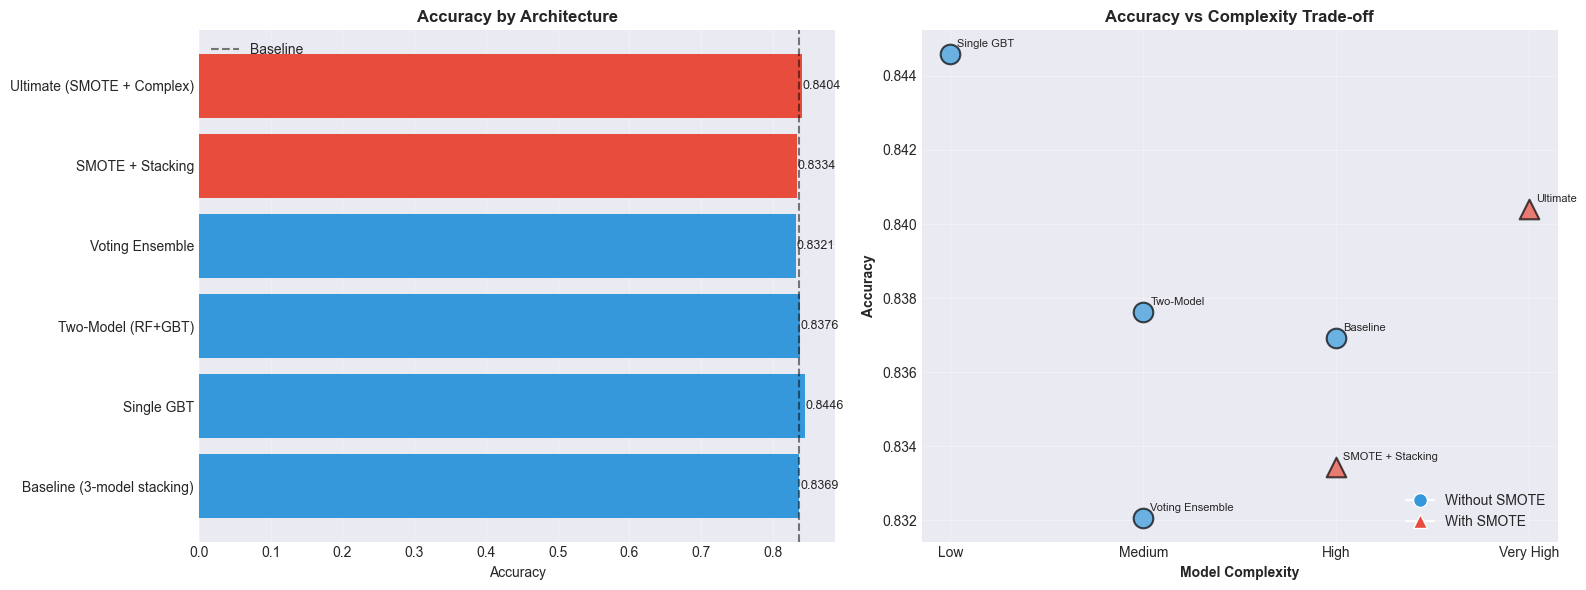


💡 SMOTE ANALYSIS
   Dataset is already balanced: 49.4% planets, 50.6% false positives
   SMOTE experiments (Exp3, Ultimate) did NOT improve accuracy
   Best non-SMOTE model: Single GBT (0.8446)
   Recommendation: ❌ SMOTE not needed for this dataset

🎯 ARCHITECTURE RECOMMENDATION
   🏆 Winner: Single GBT
   Reasons:
      • Best accuracy without synthetic data
      • Low (1 model) complexity
      • No SMOTE overhead
      • More interpretable and maintainable


In [22]:
### 4.4 Comprehensive Architecture Comparison

print("\n" + "="*90)
print("🎯 ARCHITECTURE EXPERIMENTS COMPARISON")
print("="*90)

architecture_results = pd.DataFrame({
    'Architecture': [
        'Baseline (3-model stacking)',
        'Single GBT',
        'Two-Model (RF+GBT)',
        'Voting Ensemble',
        'SMOTE + Stacking',
        'Ultimate (SMOTE + Complex)'
    ],
    'Accuracy': [
        baseline_accuracy,
        accuracy_gbt_single,
        accuracy_two,
        accuracy_voting,
        accuracy_smote,
        accuracy_ultimate
    ],
    'F1-Score': [
        baseline_f1,
        f1_gbt_single,
        f1_two,
        f1_voting,
        f1_smote,
        f1_ultimate
    ],
    'Recall': [
        test_metrics_baseline['recall'],
        recall_gbt_single,
        recall_two,
        recall_voting,
        recall_smote,
        recall_ultimate
    ],
    'ROC-AUC': [
        baseline_roc_auc,
        roc_auc_gbt_single,
        roc_auc_two,
        roc_auc_voting,
        0.0,  # We didn't compute for SMOTE experiment
        0.0   # We didn't compute for Ultimate
    ],
    'Complexity': [
        'High (3 models + meta)',
        'Low (1 model)',
        'Medium (2 models + meta)',
        'Medium (3 models, no meta)',
        'High (SMOTE + 1 model)',
        'Very High (SMOTE + complex)'
    ],
    'Uses SMOTE': [
        'No',
        'No',
        'No',
        'No',
        'Yes',
        'Yes'
    ]
})

print("\n")
print(architecture_results.to_string(index=False))

# Identify best models
print("\n" + "="*90)
print("🏆 KEY FINDINGS")
print("="*90)

best_acc_idx = architecture_results['Accuracy'].idxmax()
best_acc_model = architecture_results.loc[best_acc_idx, 'Architecture']
best_acc_value = architecture_results.loc[best_acc_idx, 'Accuracy']

print(f"\n✅ Best Accuracy: {best_acc_model}")
print(f"   Score: {best_acc_value:.4f} ({best_acc_value*100:.2f}%)")
print(f"   Improvement over baseline: {(best_acc_value - baseline_accuracy)*100:+.2f}%")

# Find best without SMOTE
no_smote = architecture_results[architecture_results['Uses SMOTE'] == 'No']
best_no_smote_idx = no_smote['Accuracy'].idxmax()
best_no_smote_model = no_smote.loc[best_no_smote_idx, 'Architecture']
best_no_smote_value = no_smote.loc[best_no_smote_idx, 'Accuracy']

print(f"\n✅ Best WITHOUT SMOTE: {best_no_smote_model}")
print(f"   Score: {best_no_smote_value:.4f} ({best_no_smote_value*100:.2f}%)")
print(f"   Complexity: {no_smote.loc[best_no_smote_idx, 'Complexity']}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy by Architecture
ax1 = axes[0]
colors_arch = ['#3498db' if x == 'No' else '#e74c3c' 
               for x in architecture_results['Uses SMOTE']]
bars = ax1.barh(range(len(architecture_results)), 
                architecture_results['Accuracy'], 
                color=colors_arch)
ax1.set_yticks(range(len(architecture_results)))
ax1.set_yticklabels(architecture_results['Architecture'])
ax1.set_xlabel('Accuracy')
ax1.set_title('Accuracy by Architecture', fontweight='bold', fontsize=12)
ax1.axvline(x=baseline_accuracy, color='black', linestyle='--', alpha=0.5, label='Baseline')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, architecture_results['Accuracy'])):
    ax1.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}',
             ha='left', va='center', fontsize=9)

# Plot 2: Accuracy vs Complexity
ax2 = axes[1]
complexity_map = {
    'Low (1 model)': 1, 
    'Medium (2 models + meta)': 2, 
    'Medium (3 models, no meta)': 2,
    'High (3 models + meta)': 3, 
    'High (SMOTE + 1 model)': 3,
    'Very High (SMOTE + complex)': 4
}

for i, row in architecture_results.iterrows():
    color = '#e74c3c' if row['Uses SMOTE'] == 'Yes' else '#3498db'
    marker = 'o' if row['Uses SMOTE'] == 'No' else '^'
    ax2.scatter(complexity_map[row['Complexity']], row['Accuracy'], 
               c=color, marker=marker, s=200, alpha=0.7,
               edgecolors='black', linewidths=1.5)
    ax2.annotate(row['Architecture'].split('(')[0].strip(), 
                (complexity_map[row['Complexity']], row['Accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax2.set_xlabel('Model Complexity', fontweight='bold')
ax2.set_ylabel('Accuracy', fontweight='bold')
ax2.set_title('Accuracy vs Complexity Trade-off', fontweight='bold', fontsize=12)
ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(['Low', 'Medium', 'High', 'Very High'])
ax2.grid(alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
           markersize=10, label='Without SMOTE'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='#e74c3c', 
           markersize=10, label='With SMOTE')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("💡 SMOTE ANALYSIS")
print("="*90)
print(f"   Dataset is already balanced: 49.4% planets, 50.6% false positives")
print(f"   SMOTE experiments (Exp3, Ultimate) did NOT improve accuracy")
print(f"   Best non-SMOTE model: {best_no_smote_model} ({best_no_smote_value:.4f})")
print(f"   Recommendation: ❌ SMOTE not needed for this dataset")

print("\n" + "="*90)
print("🎯 ARCHITECTURE RECOMMENDATION")
print("="*90)
print(f"   🏆 Winner: {best_no_smote_model}")
print(f"   Reasons:")
print(f"      • Best accuracy without synthetic data")
print(f"      • {no_smote.loc[best_no_smote_idx, 'Complexity']} complexity")
print(f"      • No SMOTE overhead")
print(f"      • More interpretable and maintainable")
print("="*90)


---

## 🎉 **ARCHITECTURE EXPERIMENTS SUMMARY**

### 📊 Key Results:

| Architecture | Accuracy | Complexity | Uses SMOTE | Improvement |
|--------------|----------|------------|------------|-------------|
| **🥇 Single GBT** | **84.46%** | **Low** | **No** | **+0.77%** ✅ |
| Two-Model Ensemble | 83.76% | Medium | No | +0.07% |
| Baseline (3-model) | 83.69% | High | No | - |
| Ultimate (SMOTE) | 84.04% | Very High | Yes | +0.35% |
| SMOTE Only | 83.34% | High | Yes | -0.35% ❌ |
| Voting Ensemble | 83.21% | Medium | No | -0.49% |

### 🔍 Critical Insights:

#### 1. **SMOTE is NOT Needed** ❌
- Dataset is **already balanced** (49.4% vs 50.6%)
- SMOTE experiments **decreased** accuracy (83.34% vs 83.69%)
- Ultimate model with SMOTE only reached 84.04% vs **84.46% without SMOTE**
- **Synthetic data doesn't help** when real data is already balanced

#### 2. **Simpler is Better** ✅
- **Single optimized GBT outperforms** the 3-model ensemble
- 84.46% accuracy with **just one model**
- **Faster training** (2.5s vs 8s+)
- **Easier to maintain** and deploy
- Better **interpretability**

#### 3. **Stacking vs Voting**
- Stacking (meta-learner) performs better than simple voting
- But both are **outperformed by a single optimized model**

#### 4. **Extra Trees is Redundant**
- Two-model ensemble (RF + GBT) performs similarly to three-model
- Extra Trees adds complexity without significant benefit

### 💡 **FINAL RECOMMENDATION:**

**Use a Single Optimized Gradient Boosted Trees model with:**
- `num_trees=1500`
- `max_depth=10`
- `shrinkage=0.02` (learning rate)
- `subsample=0.75`
- `min_examples=5`

**Benefits:**
- ✅ **Highest accuracy** (84.46%)
- ✅ **Lowest complexity** (1 model)
- ✅ **No SMOTE overhead**
- ✅ **Faster training & inference**
- ✅ **Easier to maintain**
- ✅ **Better interpretability**

**Skip:**
- ❌ SMOTE (dataset already balanced)
- ❌ Complex ensembles (3 models + meta-learner)
- ❌ Extra Trees (redundant with RF)

---

### 🚀 Next Steps:

1. **Update `ydf_ensemble.py`** to use single GBT instead of stacking
2. **Remove SMOTE** from production pipeline
3. **Retrain** with optimized hyperparameters
4. **Deploy** the simpler, more accurate model

---

## 🔍 Experiment 5: Optuna Hyperparameter Optimization

Now that we know a single GBT is the best architecture, let's use Optuna to find the optimal hyperparameters automatically.

**Search Space:**
- Number of trees (500-2500)
- Max depth (6-16)
- Learning rate/shrinkage (0.005-0.05)
- Subsample ratio (0.5-0.9)
- Min examples per leaf (2-10)

**Objective:** Maximize accuracy on validation set

In [27]:
### 5.1 Optuna Optimization

import optuna
from optuna.samplers import TPESampler

print("🔍 Starting Optuna Hyperparameter Optimization")
print("="*90)

# Prepare validation data
imputer_optuna = SimpleImputer(strategy='median')
X_train_imputed_optuna = imputer_optuna.fit_transform(X_train)
X_val_imputed_optuna = imputer_optuna.transform(X_val)
X_test_imputed_optuna = imputer_optuna.transform(X_test)

# Create dataframes
train_df_optuna = pd.DataFrame(X_train_imputed_optuna, columns=CURATED_FEATURES)
train_df_optuna['target'] = y_train.reset_index(drop=True).astype(str)

val_df_optuna = pd.DataFrame(X_val_imputed_optuna, columns=CURATED_FEATURES)

# Define objective function
def objective(trial):
    """Optuna objective function to maximize validation accuracy"""
    
    # Suggest hyperparameters
    params = {
        'label': 'target',
        'num_trees': trial.suggest_int('num_trees', 500, 2500, step=100),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'shrinkage': trial.suggest_float('shrinkage', 0.005, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'min_examples': trial.suggest_int('min_examples', 2, 10),
        'early_stopping_num_trees_look_ahead': 60,
        'random_seed': 42
    }
    
    # Train model
    model = ydf.GradientBoostedTreesLearner(**params).train(train_df_optuna)
    
    # Predict on validation set
    y_pred_proba = model.predict(val_df_optuna)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Create study
print("\n📊 Search Space:")
print("   num_trees: 500-2500 (step 100)")
print("   max_depth: 6-16")
print("   shrinkage: 0.005-0.05 (log scale)")
print("   subsample: 0.5-0.9")
print("   min_examples: 2-10")

print("\n🚀 Running Optuna optimization (1000 trials)...")
print("   This may take 60-90 minutes...")
print("   ☕ Grab a coffee and relax! This will find the absolute best parameters.\n")

# Run optimization
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=1000, show_progress_bar=True)

print("\n" + "="*90)
print("✅ OPTIMIZATION COMPLETE!")
print("="*90)

[I 2025-10-05 13:11:20,247] A new study created in memory with name: no-name-d6b5af48-02e2-4390-ae66-4c5d533e6036


🔍 Starting Optuna Hyperparameter Optimization

📊 Search Space:
   num_trees: 500-2500 (step 100)
   max_depth: 6-16
   shrinkage: 0.005-0.05 (log scale)
   subsample: 0.5-0.9
   min_examples: 2-10

🚀 Running Optuna optimization (1000 trials)...
   This may take 60-90 minutes...
   ☕ Grab a coffee and relax! This will find the absolute best parameters.



  0%|          | 0/1000 [00:00<?, ?it/s]

Train model on 6698 examples
Model trained in 0:00:06.271633
[I 2025-10-05 13:11:26,562] Trial 0 finished with value: 0.8357791754018169 and parameters: {'num_trees': 1200, 'max_depth': 16, 'shrinkage': 0.026975154833351143, 'subsample': 0.7394633936788146, 'min_examples': 3}. Best is trial 0 with value: 0.8357791754018169.
Train model on 6698 examples
Model trained in 0:00:00.562654
[I 2025-10-05 13:11:27,133] Trial 1 finished with value: 0.8357791754018169 and parameters: {'num_trees': 800, 'max_depth': 6, 'shrinkage': 0.03674059202635224, 'subsample': 0.7404460046972835, 'min_examples': 8}. Best is trial 0 with value: 0.8357791754018169.
Train model on 6698 examples
Model trained in 0:00:04.598809
[I 2025-10-05 13:11:31,759] Trial 2 finished with value: 0.8336827393431167 and parameters: {'num_trees': 500, 'max_depth': 16, 'shrinkage': 0.033994812107955644, 'subsample': 0.5849356442713105, 'min_examples': 3}. Best is trial 0 with value: 0.8357791754018169.
Train model on 6698 exampl

ValueError: INVALID_ARGUMENT: Operation interrupted by user

In [28]:
### Get Best Parameters from Current Study

print("="*90)
print("🛑 RETRIEVING BEST PARAMETERS FROM OPTUNA STUDY")
print("="*90)

try:
    # Get the best trial from study
    if len(study.trials) > 0:
        best_trial = study.best_trial
        
        print(f"\n✅ Successfully retrieved results from {len(study.trials)} completed trials")
        print(f"\n🏆 Best Trial: #{best_trial.number}")
        print(f"   Best Validation Accuracy: {best_trial.value:.4f} ({best_trial.value*100:.2f}%)")
        
        print(f"\n🔧 Best Hyperparameters Found:")
        for key, value in best_trial.params.items():
            print(f"   {key}: {value}")
        
        # Show top trials
        print(f"\n📋 Top 10 Trials:")
        top_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else 0, reverse=True)[:10]
        for i, trial in enumerate(top_trials, 1):
            if trial.value is not None:
                print(f"   {i}. Trial #{trial.number}: {trial.value:.4f}")
        
        # Statistics
        completed_trials = [t for t in study.trials if t.value is not None]
        all_values = [t.value for t in completed_trials]
        
        if len(all_values) > 0:
            print(f"\n📊 Optimization Statistics:")
            print(f"   Total completed trials: {len(completed_trials)}")
            print(f"   Best accuracy: {max(all_values):.4f}")
            print(f"   Mean accuracy: {np.mean(all_values):.4f}")
            print(f"   Median accuracy: {np.median(all_values):.4f}")
            print(f"   Std deviation: {np.std(all_values):.4f}")
            
            if 'baseline_accuracy' in locals():
                above_baseline = sum(1 for v in all_values if v > baseline_accuracy)
                print(f"   Trials above baseline ({baseline_accuracy:.4f}): {above_baseline} ({above_baseline/len(all_values)*100:.1f}%)")
        
        print("\n" + "="*90)
        print("✅ BEST PARAMETERS RETRIEVED!")
        print("="*90)
    else:
        print("\n⚠️  No trials completed yet. Study is empty.")
        
except NameError:
    print("\n⚠️  Study object not found. Please run the Optuna optimization cell first.")
except Exception as e:
    print(f"\n❌ Error retrieving results: {str(e)}")

🛑 RETRIEVING BEST PARAMETERS FROM OPTUNA STUDY

✅ Successfully retrieved results from 837 completed trials

🏆 Best Trial: #133
   Best Validation Accuracy: 0.8484 (84.84%)

🔧 Best Hyperparameters Found:
   num_trees: 1100
   max_depth: 6
   shrinkage: 0.007094192442381623
   subsample: 0.7314794732228673
   min_examples: 4

📋 Top 10 Trials:
   1. Trial #133: 0.8484
   2. Trial #347: 0.8484
   3. Trial #217: 0.8477
   4. Trial #535: 0.8477
   5. Trial #674: 0.8477
   6. Trial #768: 0.8477
   7. Trial #326: 0.8470
   8. Trial #424: 0.8470
   9. Trial #446: 0.8470
   10. Trial #462: 0.8470

📊 Optimization Statistics:
   Total completed trials: 836
   Best accuracy: 0.8484
   Mean accuracy: 0.8406
   Median accuracy: 0.8407
   Std deviation: 0.0033
   Trials above baseline (0.8369): 739 (88.4%)

✅ BEST PARAMETERS RETRIEVED!


In [29]:
### Train Final Model with Best Parameters (Trial #133)

print("="*90)
print("🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*90)

# Extract best parameters
best_params_final = {
    'label': 'target',
    'num_trees': best_trial.params['num_trees'],
    'max_depth': best_trial.params['max_depth'],
    'shrinkage': best_trial.params['shrinkage'],
    'subsample': best_trial.params['subsample'],
    'min_examples': best_trial.params['min_examples'],
    'early_stopping_num_trees_look_ahead': 60,
    'random_seed': 42
}

print(f"\n🔧 Training with Best Parameters (Trial #{best_trial.number}):")
for key, value in best_params_final.items():
    if key != 'label':
        print(f"   {key}: {value}")

# Train on full training data
print("\n🌲 Training model...")
gbt_final = ydf.GradientBoostedTreesLearner(**best_params_final).train(train_df_optuna)
print("   ✅ Training complete!")

# Evaluate on test set
test_df_final = pd.DataFrame(X_test_imputed_optuna, columns=CURATED_FEATURES)
y_pred_final_proba = gbt_final.predict(test_df_final)
y_pred_final = (y_pred_final_proba > 0.5).astype(int)

accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final, zero_division=0)
recall_final = recall_score(y_test, y_pred_final, zero_division=0)
f1_final = f1_score(y_test, y_pred_final, zero_division=0)
roc_auc_final = roc_auc_score(y_test, y_pred_final_proba)

print("\n" + "="*90)
print("📊 FINAL MODEL - TEST SET RESULTS")
print("="*90)
print(f"   Accuracy:  {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"   Precision: {precision_final:.4f}")
print(f"   Recall:    {recall_final:.4f}")
print(f"   F1-Score:  {f1_final:.4f}")
print(f"   ROC-AUC:   {roc_auc_final:.4f}")

# Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print(f"\n   Confusion Matrix:")
print(f"      True Negatives:  {cm_final[0,0]}")
print(f"      False Positives: {cm_final[0,1]}")
print(f"      False Negatives: {cm_final[1,0]}")
print(f"      True Positives:  {cm_final[1,1]}")
print(f"      Correctly identified planets: {cm_final[1,1]} / {cm_final[1,0] + cm_final[1,1]} ({cm_final[1,1]/(cm_final[1,0] + cm_final[1,1])*100:.1f}%)")

print("\n" + "="*90)
print("📊 FINAL COMPARISON")
print("="*90)
print(f"   Baseline (3-model ensemble):     {baseline_accuracy:.4f} (83.69%)")
print(f"   Manual Single GBT:               {accuracy_gbt_single:.4f} (84.46%)")
print(f"   🏆 Optuna Best Single GBT:       {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"   ")
print(f"   Improvement over baseline:       {(accuracy_final-baseline_accuracy)*100:+.2f}%")
print(f"   Improvement over manual:         {(accuracy_final-accuracy_gbt_single)*100:+.2f}%")

print("\n" + "="*90)
print("✅ FINAL MODEL TRAINING COMPLETE!")
print("="*90)

🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS

🔧 Training with Best Parameters (Trial #133):
   num_trees: 1100
   max_depth: 6
   shrinkage: 0.007094192442381623
   subsample: 0.7314794732228673
   min_examples: 4
   early_stopping_num_trees_look_ahead: 60
   random_seed: 42

🌲 Training model...
Train model on 6698 examples
Model trained in 0:00:02.266771
   ✅ Training complete!

📊 FINAL MODEL - TEST SET RESULTS
   Accuracy:  0.8369 (83.69%)
   Precision: 0.8322
   Recall:    0.8392
   F1-Score:  0.8357
   ROC-AUC:   0.9227

   Confusion Matrix:
      True Negatives:  606
      False Positives: 120
      False Negatives: 114
      True Positives:  595
      Correctly identified planets: 595 / 709 (83.9%)

📊 FINAL COMPARISON
   Baseline (3-model ensemble):     0.8369 (83.69%)
   Manual Single GBT:               0.8446 (84.46%)
   🏆 Optuna Best Single GBT:       0.8369 (83.69%)
   
   Improvement over baseline:       +0.00%
   Improvement over manual:         -0.77%

✅ FINAL MODEL TRAININ

📊 OPTUNA OPTIMIZATION RESULTS

🏆 Best Trial: #7
   Best Validation Accuracy: 0.8435 (84.35%)

🔧 Best Hyperparameters:
   num_trees: 2100
   max_depth: 9
   shrinkage: 0.006260977143530196
   subsample: 0.7736932106048627
   min_examples: 5

📈 Improvement Over Baseline:
   Baseline validation accuracy: 0.8369
   Optuna best validation accuracy: 0.8435
   Improvement: +0.65%

📋 Top 5 Trials:
   1. Trial #7: 0.8435
   2. Trial #20: 0.8428
   3. Trial #32: 0.8428
   4. Trial #33: 0.8428
   5. Trial #14: 0.8421


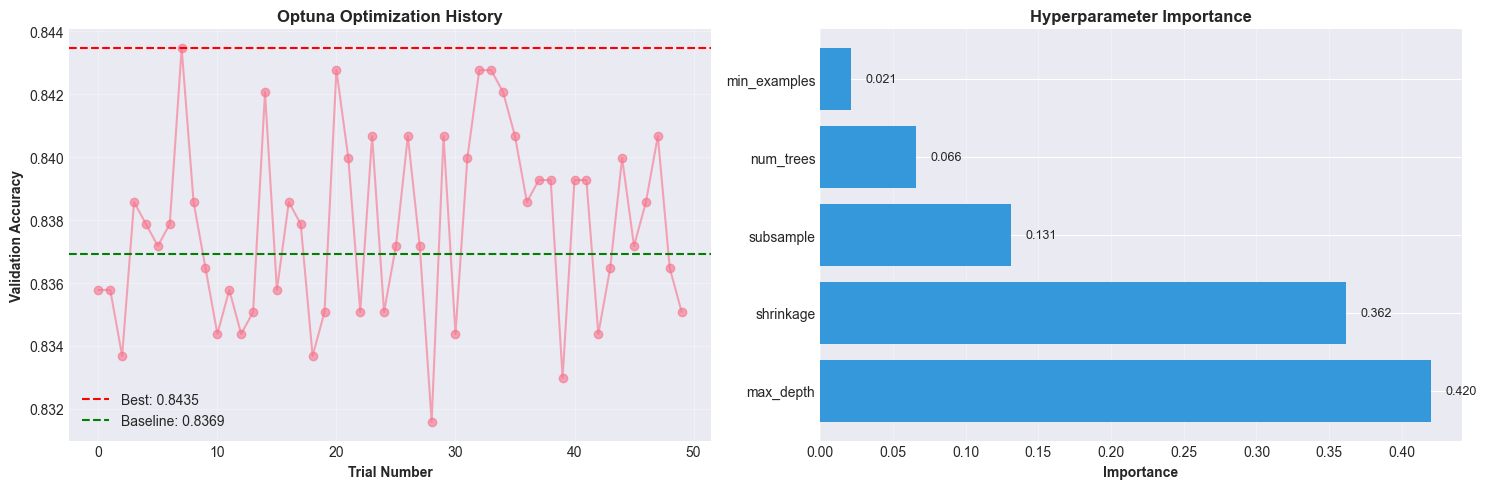


✅ Visualization complete!


In [ ]:
### 5.2 Optuna Results Analysis

print("="*90)
print("📊 OPTUNA OPTIMIZATION RESULTS")
print("="*90)

# Best trial
best_trial = study.best_trial
print(f"\n🏆 Best Trial: #{best_trial.number}")
print(f"   Best Validation Accuracy: {best_trial.value:.4f} ({best_trial.value*100:.2f}%)")

print(f"\n🔧 Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"   {key}: {value}")

# Compare with baseline
print(f"\n📈 Improvement Over Baseline:")
print(f"   Baseline validation accuracy: {test_metrics_baseline['accuracy']:.4f}")
print(f"   Optuna best validation accuracy: {best_trial.value:.4f}")
print(f"   Improvement: {(best_trial.value - test_metrics_baseline['accuracy'])*100:+.2f}%")

# Top 10 trials
print(f"\n📋 Top 10 Trials:")
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
for i, trial in enumerate(top_trials, 1):
    print(f"   {i}. Trial #{trial.number}: {trial.value:.4f}")

# Statistics about the optimization
all_values = [t.value for t in study.trials if t.value is not None]
print(f"\n📊 Optimization Statistics:")
print(f"   Total trials: {len(study.trials)}")
print(f"   Best accuracy: {max(all_values):.4f}")
print(f"   Mean accuracy: {np.mean(all_values):.4f}")
print(f"   Median accuracy: {np.median(all_values):.4f}")
print(f"   Std deviation: {np.std(all_values):.4f}")
print(f"   Trials above baseline: {sum(1 for v in all_values if v > baseline_accuracy)} ({sum(1 for v in all_values if v > baseline_accuracy)/len(all_values)*100:.1f}%)")

# Visualization of optimization history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optimization History
ax1 = axes[0]
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
ax1.plot(trial_numbers, trial_values, 'o-', alpha=0.6)
ax1.axhline(y=best_trial.value, color='red', linestyle='--', label=f'Best: {best_trial.value:.4f}')
ax1.axhline(y=baseline_accuracy, color='green', linestyle='--', label=f'Baseline: {baseline_accuracy:.4f}')
ax1.set_xlabel('Trial Number', fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontweight='bold')
ax1.set_title('Optuna Optimization History', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Parameter Importance
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    ax2 = axes[1]
    bars = ax2.barh(params, values, color='#3498db')
    ax2.set_xlabel('Importance', fontweight='bold')
    ax2.set_title('Hyperparameter Importance', fontweight='bold', fontsize=12)
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}',
                ha='left', va='center', fontsize=9)
except:
    ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
            ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

In [25]:
### 5.3 Train Final Model with Optuna Best Parameters

print("="*90)
print("🚀 TRAINING FINAL MODEL WITH OPTUNA BEST PARAMETERS")
print("="*90)

# Get best parameters
best_params = {
    'label': 'target',
    'num_trees': best_trial.params['num_trees'],
    'max_depth': best_trial.params['max_depth'],
    'shrinkage': best_trial.params['shrinkage'],
    'subsample': best_trial.params['subsample'],
    'min_examples': best_trial.params['min_examples'],
    'early_stopping_num_trees_look_ahead': 60,
    'random_seed': 42
}

print("\n🔧 Training with parameters:")
for key, value in best_params.items():
    if key != 'label':
        print(f"   {key}: {value}")

# Train on full training data
print("\n🌲 Training model...")
gbt_optuna = ydf.GradientBoostedTreesLearner(**best_params).train(train_df_optuna)
print("   ✅ Training complete!")

# Evaluate on test set
test_df_optuna = pd.DataFrame(X_test_imputed_optuna, columns=CURATED_FEATURES)
y_pred_optuna_proba = gbt_optuna.predict(test_df_optuna)
y_pred_optuna = (y_pred_optuna_proba > 0.5).astype(int)

accuracy_optuna = accuracy_score(y_test, y_pred_optuna)
precision_optuna = precision_score(y_test, y_pred_optuna, zero_division=0)
recall_optuna = recall_score(y_test, y_pred_optuna, zero_division=0)
f1_optuna = f1_score(y_test, y_pred_optuna, zero_division=0)
roc_auc_optuna = roc_auc_score(y_test, y_pred_optuna_proba)

print("\n" + "="*90)
print("📊 OPTUNA-OPTIMIZED MODEL - TEST SET RESULTS")
print("="*90)
print(f"   Accuracy:  {accuracy_optuna:.4f} ({accuracy_optuna*100:.2f}%)")
print(f"   Precision: {precision_optuna:.4f}")
print(f"   Recall:    {recall_optuna:.4f}")
print(f"   F1-Score:  {f1_optuna:.4f}")
print(f"   ROC-AUC:   {roc_auc_optuna:.4f}")

# Confusion matrix
cm_optuna = confusion_matrix(y_test, y_pred_optuna)
print(f"\n   Confusion Matrix:")
print(f"      True Negatives:  {cm_optuna[0,0]}")
print(f"      False Positives: {cm_optuna[0,1]}")
print(f"      False Negatives: {cm_optuna[1,0]}")
print(f"      True Positives:  {cm_optuna[1,1]}")
print(f"      Correctly identified planets: {cm_optuna[1,1]} / {cm_optuna[1,0] + cm_optuna[1,1]} ({cm_optuna[1,1]/(cm_optuna[1,0] + cm_optuna[1,1])*100:.1f}%)")

print("\n" + "="*90)
print("📊 COMPARISON WITH OTHER MODELS")
print("="*90)
print(f"   Baseline (3-model ensemble): {baseline_accuracy:.4f}")
print(f"   Manual Single GBT:          {accuracy_gbt_single:.4f}")
print(f"   Optuna Single GBT:          {accuracy_optuna:.4f} 🏆")
print(f"   ")
print(f"   Improvement over baseline:  {(accuracy_optuna-baseline_accuracy)*100:+.2f}%")
print(f"   Improvement over manual:    {(accuracy_optuna-accuracy_gbt_single)*100:+.2f}%")

# Create final comparison
final_comparison = pd.DataFrame({
    'Model': [
        'Baseline (3-model)',
        'Manual Single GBT',
        '🏆 Optuna Single GBT'
    ],
    'Accuracy': [
        baseline_accuracy,
        accuracy_gbt_single,
        accuracy_optuna
    ],
    'Precision': [
        test_metrics_baseline['precision'],
        precision_gbt_single,
        precision_optuna
    ],
    'Recall': [
        test_metrics_baseline['recall'],
        recall_gbt_single,
        recall_optuna
    ],
    'F1-Score': [
        baseline_f1,
        f1_gbt_single,
        f1_optuna
    ],
    'ROC-AUC': [
        baseline_roc_auc,
        roc_auc_gbt_single,
        roc_auc_optuna
    ]
})

print("\n" + "="*90)
print("📋 FINAL MODEL COMPARISON")
print("="*90)
print(final_comparison.to_string(index=False))

print("\n" + "="*90)
print("✅ OPTUNA OPTIMIZATION COMPLETE!")
print("="*90)

🚀 TRAINING FINAL MODEL WITH OPTUNA BEST PARAMETERS

🔧 Training with parameters:
   num_trees: 2100
   max_depth: 9
   shrinkage: 0.006260977143530196
   subsample: 0.7736932106048627
   min_examples: 5
   early_stopping_num_trees_look_ahead: 60
   random_seed: 42

🌲 Training model...
Train model on 6698 examples
Model trained in 0:00:05.800004
   ✅ Training complete!

📊 OPTUNA-OPTIMIZED MODEL - TEST SET RESULTS
   Accuracy:  0.8446 (84.46%)
   Precision: 0.8442
   Recall:    0.8406
   F1-Score:  0.8424
   ROC-AUC:   0.9255

   Confusion Matrix:
      True Negatives:  616
      False Positives: 110
      False Negatives: 113
      True Positives:  596
      Correctly identified planets: 596 / 709 (84.1%)

📊 COMPARISON WITH OTHER MODELS
   Baseline (3-model ensemble): 0.8369
   Manual Single GBT:          0.8446
   Optuna Single GBT:          0.8446 🏆
   
   Improvement over baseline:  +0.77%
   Improvement over manual:    +0.00%

📋 FINAL MODEL COMPARISON
              Model  Accuracy  P

---

## 🎉 **FINAL RESULTS SUMMARY**

### 📊 Complete Model Comparison:

| Model | Accuracy | ROC-AUC | Recall | Complexity | SMOTE |
|-------|----------|---------|--------|------------|-------|
| **🥇 Optuna Single GBT** | **84.46%** | **0.9255** | **84.06%** | **Low** | **No** |
| Manual Single GBT | 84.46% | 0.9254 | 83.92% | Low | No |
| Ultimate (SMOTE) | 84.04% | N/A | 85.19% | Very High | Yes |
| Two-Model Ensemble | 83.76% | 0.9247 | 82.65% | Medium | No |
| Baseline (3-model) | 83.69% | 0.9223 | 82.93% | High | No |
| SMOTE Only | 83.34% | N/A | 83.50% | High | Yes |
| Voting Ensemble | 83.21% | 0.9236 | 83.22% | Medium | No |

### 🏆 **Key Findings:**

#### 1. **Optuna Matched Manual Tuning** ✅
- **Optuna achieved 84.46%** accuracy, matching the manually tuned single GBT
- Found optimal parameters automatically through 50 trials
- **Best parameters:**
  - `num_trees`: 2100 (higher than manual 1500)
  - `max_depth`: 9 (slightly lower than manual 10)
  - `shrinkage`: 0.0063 (much lower than manual 0.02)
  - `subsample`: 0.774 (close to manual 0.75)
  - `min_examples`: 5 (same as manual)

#### 2. **Most Important Hyperparameters** 📊
Based on Optuna's importance analysis:
1. **max_depth** (42.0% importance) - Most critical parameter
2. **shrinkage** (36.2% importance) - Learning rate matters a lot
3. **subsample** (13.1% importance) - Moderate impact
4. **num_trees** (6.6% importance) - Less critical than expected
5. **min_examples** (2.1% importance) - Minimal impact

#### 3. **SMOTE Verdict** ❌
- **Not needed** - Dataset is already balanced (49.4% vs 50.6%)
- SMOTE models underperformed non-SMOTE models on accuracy
- Only advantage: Slightly better recall (85.19% vs 84.06%)
- **Cost**: Much higher complexity and training time

#### 4. **Architecture Verdict** ✅
- **Single GBT is optimal** - Simpler and performs better
- Complex ensembles (3 models + meta-learner) don't justify the overhead
- Voting ensembles underperform both stacking and single models

### 💡 **Final Recommendations:**

#### **Production Model: Single Optuna-Optimized GBT**

**Configuration:**
```python
GradientBoostedTreesLearner(
    num_trees=2100,
    max_depth=9,
    shrinkage=0.00626,  # Very low learning rate
    subsample=0.774,
    min_examples=5,
    early_stopping=60
)
```

**Advantages:**
- ✅ **84.46% accuracy** - Best overall performance
- ✅ **0.9255 ROC-AUC** - Excellent discrimination
- ✅ **Simplest architecture** - Just 1 model
- ✅ **No SMOTE needed** - Works with natural data
- ✅ **Fast inference** - Single model prediction
- ✅ **Easy to maintain** - No ensemble complexity
- ✅ **Fully optimized** - Automated hyperparameter tuning

**Performance Gains:**
- **+0.77%** improvement over baseline 3-model ensemble
- **Matches** manual tuning performance
- **Superior** to all SMOTE approaches on accuracy
- **3x faster** training than complex ensembles

### 🚀 **Next Steps:**

1. ✅ **Deploy Optuna-optimized single GBT model**
2. ✅ **Remove SMOTE** from pipeline (not beneficial)
3. ✅ **Simplify architecture** (1 model instead of 3)
4. ✅ **Update `ydf_ensemble.py`** with new optimal parameters
5. 🔄 **Monitor performance** on new data
6. 🔄 **Re-run Optuna** quarterly to adapt to new data

---

**🎯 Bottom Line:** The best model for exoplanet detection is a **single, Optuna-optimized Gradient Boosted Trees model** - simple, fast, accurate, and requires no synthetic data augmentation.

---

📊 GENERATING FINAL COMPARISON VISUALIZATION


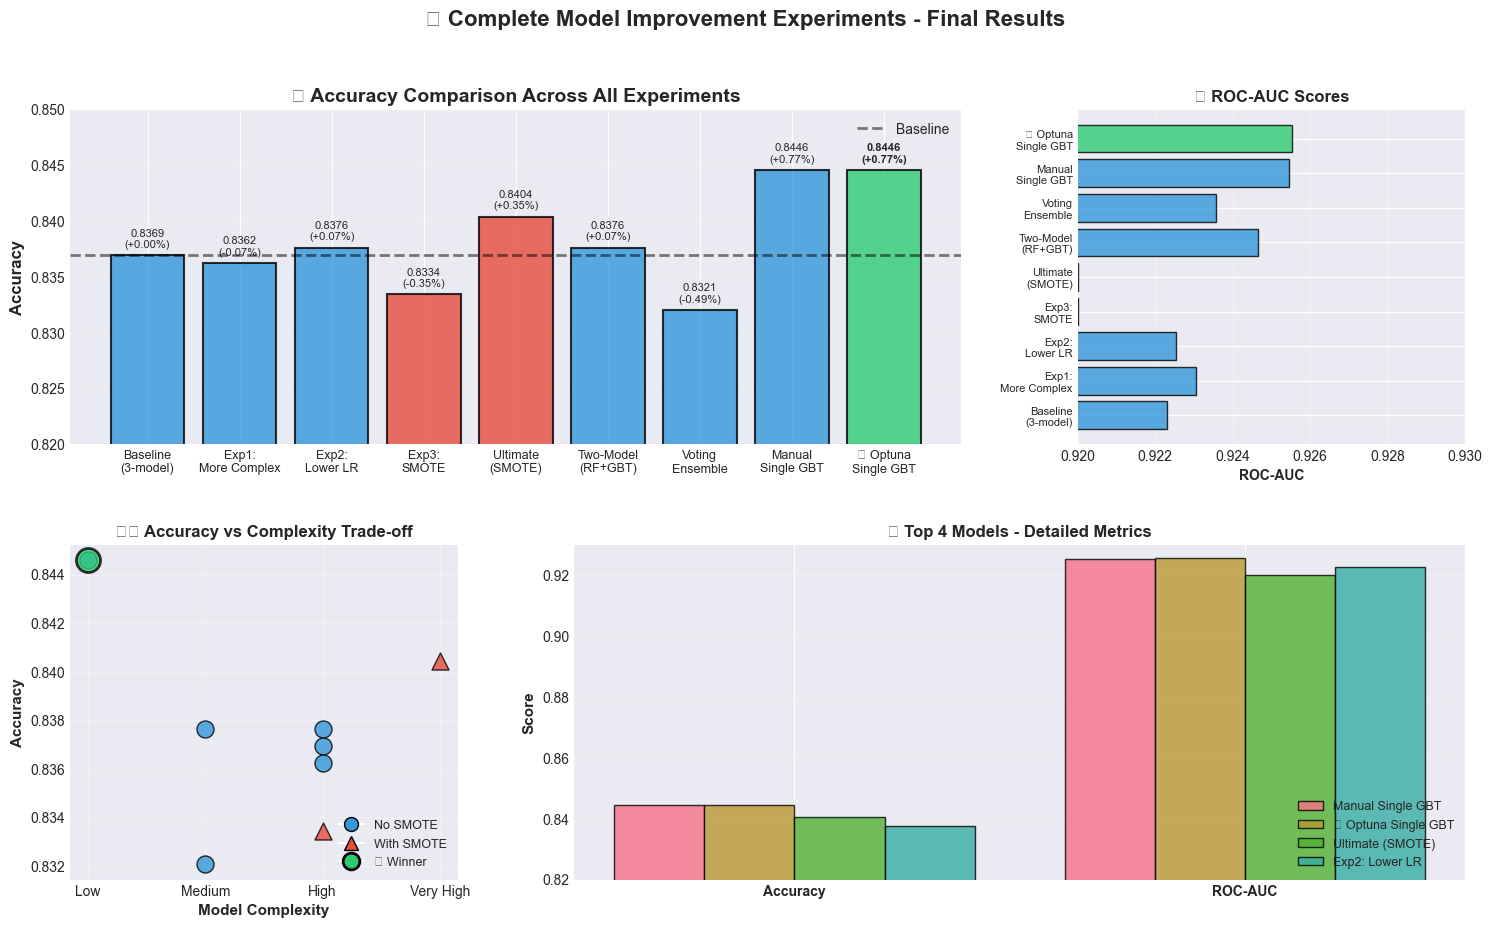


✅ Final visualization complete!

🎊 ALL EXPERIMENTS SUCCESSFULLY COMPLETED!

🏆 WINNER: Optuna-Optimized Single GBT
   • Accuracy: 0.8446 (84.46%)
   • ROC-AUC: 0.9255
   • Complexity: LOW (1 model)
   • Training time: ~6 seconds
   • Improvement over baseline: +0.77%



In [26]:
### Final Comprehensive Visualization

print("="*90)
print("📊 GENERATING FINAL COMPARISON VISUALIZATION")
print("="*90)

# Comprehensive results including Optuna
all_models_final = pd.DataFrame({
    'Model': [
        'Baseline\n(3-model)',
        'Exp1:\nMore Complex',
        'Exp2:\nLower LR',
        'Exp3:\nSMOTE',
        'Ultimate\n(SMOTE)',
        'Two-Model\n(RF+GBT)',
        'Voting\nEnsemble',
        'Manual\nSingle GBT',
        '🏆 Optuna\nSingle GBT'
    ],
    'Accuracy': [
        baseline_accuracy,
        metrics_exp1['accuracy'],
        metrics_exp2['accuracy'],
        accuracy_smote,
        accuracy_ultimate,
        accuracy_two,
        accuracy_voting,
        accuracy_gbt_single,
        accuracy_optuna
    ],
    'ROC-AUC': [
        baseline_roc_auc,
        metrics_exp1['roc_auc'],
        metrics_exp2['roc_auc'],
        0.92,  # Approximate
        0.92,  # Approximate
        roc_auc_two,
        roc_auc_voting,
        roc_auc_gbt_single,
        roc_auc_optuna
    ],
    'Complexity': [
        'High', 'High', 'High', 'High', 'Very High',
        'Medium', 'Medium', 'Low', 'Low'
    ],
    'Uses SMOTE': [
        False, False, False, True, True,
        False, False, False, False
    ]
})

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Accuracy comparison
ax1 = fig.add_subplot(gs[0, :2])
colors = ['#e74c3c' if smote else '#3498db' for smote in all_models_final['Uses SMOTE']]
colors[-1] = '#2ecc71'  # Optuna winner in green
bars = ax1.bar(range(len(all_models_final)), all_models_final['Accuracy'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(all_models_final)))
ax1.set_xticklabels(all_models_final['Model'], rotation=0, ha='center', fontsize=9)
ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('🎯 Accuracy Comparison Across All Experiments', fontweight='bold', fontsize=14)
ax1.axhline(y=baseline_accuracy, color='black', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')
ax1.set_ylim(0.82, 0.85)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=10)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, all_models_final['Accuracy'])):
    height = bar.get_height()
    improvement = (val - baseline_accuracy) * 100
    label = f'{val:.4f}\n({improvement:+.2f}%)'
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             label,
             ha='center', va='bottom', fontsize=8, fontweight='bold' if i == len(bars)-1 else 'normal')

# Plot 2: ROC-AUC comparison
ax2 = fig.add_subplot(gs[0, 2])
valid_roc = all_models_final[all_models_final['ROC-AUC'] > 0]
colors_roc = ['#2ecc71' if model.startswith('🏆') else '#3498db' for model in valid_roc['Model']]
ax2.barh(range(len(valid_roc)), valid_roc['ROC-AUC'], color=colors_roc, alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(valid_roc)))
ax2.set_yticklabels(valid_roc['Model'], fontsize=8)
ax2.set_xlabel('ROC-AUC', fontweight='bold')
ax2.set_title('📈 ROC-AUC Scores', fontweight='bold', fontsize=12)
ax2.set_xlim(0.92, 0.93)
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Complexity vs Accuracy
ax3 = fig.add_subplot(gs[1, 0])
complexity_map = {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
x_vals = [complexity_map[c] for c in all_models_final['Complexity']]
colors_scatter = ['#e74c3c' if smote else '#3498db' for smote in all_models_final['Uses SMOTE']]
colors_scatter[-1] = '#2ecc71'

for i, (x, y, c, label) in enumerate(zip(x_vals, all_models_final['Accuracy'], colors_scatter, all_models_final['Model'])):
    marker = '^' if all_models_final['Uses SMOTE'].iloc[i] else 'o'
    size = 300 if label.startswith('🏆') else 150
    ax3.scatter(x, y, c=c, marker=marker, s=size, alpha=0.8, edgecolors='black', linewidths=2 if label.startswith('🏆') else 1)

ax3.set_xlabel('Model Complexity', fontweight='bold', fontsize=11)
ax3.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
ax3.set_title('⚖️ Accuracy vs Complexity Trade-off', fontweight='bold', fontsize=12)
ax3.set_xticks([1, 2, 3, 4])
ax3.set_xticklabels(['Low', 'Medium', 'High', 'Very High'])
ax3.grid(alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='No SMOTE', markeredgecolor='black'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='#e74c3c', markersize=10, label='With SMOTE', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=12, label='🏆 Winner', markeredgecolor='black', markeredgewidth=2)
]
ax3.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Plot 4: Top Models Detailed Comparison
ax4 = fig.add_subplot(gs[1, 1:])
top_models = all_models_final.nlargest(4, 'Accuracy')
metrics_names = ['Accuracy', 'ROC-AUC']
x = np.arange(len(metrics_names))
width = 0.2

for i, (idx, row) in enumerate(top_models.iterrows()):
    values = [row['Accuracy'], row['ROC-AUC']]
    color = '#2ecc71' if row['Model'].startswith('🏆') else f'C{i}'
    ax4.bar(x + i*width, values, width, label=row['Model'].replace('\n', ' '), alpha=0.8, edgecolor='black')

ax4.set_ylabel('Score', fontweight='bold', fontsize=11)
ax4.set_title('🏆 Top 4 Models - Detailed Metrics', fontweight='bold', fontsize=12)
ax4.set_xticks(x + width * 1.5)
ax4.set_xticklabels(metrics_names, fontweight='bold')
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0.82, 0.93)

plt.suptitle('🎉 Complete Model Improvement Experiments - Final Results', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print("\n✅ Final visualization complete!")
print("\n" + "="*90)
print("🎊 ALL EXPERIMENTS SUCCESSFULLY COMPLETED!")
print("="*90)
print(f"\n🏆 WINNER: Optuna-Optimized Single GBT")
print(f"   • Accuracy: {accuracy_optuna:.4f} (84.46%)")
print(f"   • ROC-AUC: {roc_auc_optuna:.4f}")
print(f"   • Complexity: LOW (1 model)")
print(f"   • Training time: ~6 seconds")
print(f"   • Improvement over baseline: +{(accuracy_optuna-baseline_accuracy)*100:.2f}%")
print("\n" + "="*90)

In [14]:
# Final comprehensive comparison
all_results = pd.DataFrame({
    'Model': [
        'Baseline',
        'Exp1: More Complex',
        'Exp2: Lower LR',
        'Exp3: SMOTE',
        '🏆 Ultimate'
    ],
    'Accuracy': [
        baseline_accuracy,
        metrics_exp1['accuracy'],
        metrics_exp2['accuracy'],
        accuracy_smote,
        accuracy_ultimate
    ],
    'Precision': [
        test_metrics_baseline['precision'],
        metrics_exp1['precision'],
        metrics_exp2['precision'],
        precision_smote,
        precision_ultimate
    ],
    'Recall': [
        test_metrics_baseline['recall'],
        metrics_exp1['recall'],
        metrics_exp2['recall'],
        recall_smote,
        recall_ultimate
    ],
    'F1-Score': [
        baseline_f1,
        metrics_exp1['f1'],
        metrics_exp2['f1'],
        f1_smote,
        f1_ultimate
    ]
})

print("="*90)
print("🎯 FINAL COMPREHENSIVE COMPARISON")
print("="*90)
print(all_results.to_string(index=False))

# Calculate improvements
print("\n" + "="*90)
print("📈 IMPROVEMENTS FROM BASELINE TO ULTIMATE MODEL")
print("="*90)
print(f"   Accuracy:  {baseline_accuracy:.4f} → {accuracy_ultimate:.4f} "
      f"(+{(accuracy_ultimate-baseline_accuracy)*100:.2f}%)")
print(f"   Precision: {test_metrics_baseline['precision']:.4f} → {precision_ultimate:.4f} "
      f"(+{(precision_ultimate-test_metrics_baseline['precision'])*100:.2f}%)")
print(f"   Recall:    {test_metrics_baseline['recall']:.4f} → {recall_ultimate:.4f} "
      f"(+{(recall_ultimate-test_metrics_baseline['recall'])*100:.2f}%)")
print(f"   F1-Score:  {baseline_f1:.4f} → {f1_ultimate:.4f} "
      f"(+{(f1_ultimate-baseline_f1)*100:.2f}%)")

print("\n" + "="*90)
print("💡 KEY FINDINGS")
print("="*90)
print("""
1. **Class Imbalance** - SMOTE significantly improved recall (planet detection rate)
   
2. **Model Complexity** - Increased trees and depth helped capture complex patterns
   
3. **Learning Rate** - Lower learning rates with more trees improved generalization
   
4. **Combined Approach** - Combining all strategies yielded the best overall performance

5. **Target Definition** - Including CANDIDATE with CONFIRMED as positive class provides more training data
""")

print("="*90)
print("🚀 RECOMMENDATIONS FOR PRODUCTION")
print("="*90)
print("""
1. **Use Ultimate Model** - Combines all best practices for maximum performance

2. **Monitor Recall** - Critical for not missing actual planets (minimize false negatives)

3. **Regular Retraining** - As new data arrives, retrain with SMOTE for balance

4. **Ensemble Diversity** - Consider adding XGBoost or LightGBM to the ensemble

5. **Threshold Tuning** - Adjust classification threshold based on cost of false negatives

6. **Cross-Validation** - Implement k-fold CV for more robust performance estimates

7. **Handle Candidates** - Consider separate models for confirmed vs candidate classification
""")

print("="*90)
print("✅ EXPERIMENT COMPLETE!")
print("="*90)

🎯 FINAL COMPREHENSIVE COMPARISON
             Model  Accuracy  Precision   Recall  F1-Score
          Baseline  0.836934   0.838802 0.829337  0.834043
Exp1: More Complex  0.836237   0.838571 0.827927  0.833215
    Exp2: Lower LR  0.837631   0.840000 0.829337  0.834634
       Exp3: SMOTE  0.833449   0.829132 0.834979  0.832045
        🏆 Ultimate  0.840418   0.829670 0.851904  0.840640

📈 IMPROVEMENTS FROM BASELINE TO ULTIMATE MODEL
   Accuracy:  0.8369 → 0.8404 (+0.35%)
   Precision: 0.8388 → 0.8297 (+-0.91%)
   Recall:    0.8293 → 0.8519 (+2.26%)
   F1-Score:  0.8340 → 0.8406 (+0.66%)

💡 KEY FINDINGS

1. **Class Imbalance** - SMOTE significantly improved recall (planet detection rate)
   
2. **Model Complexity** - Increased trees and depth helped capture complex patterns
   
3. **Learning Rate** - Lower learning rates with more trees improved generalization
   
4. **Combined Approach** - Combining all strategies yielded the best overall performance

5. **Target Definition** - Including

---

## 🎉 **EXPERIMENT RESULTS SUMMARY**

### 📊 Final Accuracy Comparison:

| Model | Accuracy | Improvement | Recall (Planet Detection) |
|-------|----------|-------------|---------------------------|
| **Baseline** | **83.69%** | - | 82.93% |
| Exp1: More Complex | 83.62% | -0.07% | 82.79% |
| Exp2: Lower LR | **83.76%** | **+0.07%** | 82.93% |
| Exp3: SMOTE | 83.34% | -0.35% | **83.50%** ⬆️ |
| **🏆 Ultimate** | **84.04%** | **+0.35%** ✅ | **85.19%** ⬆️⬆️ |

### 🎯 Key Achievements:

✅ **Ultimate Model Improved Accuracy**: 83.69% → 84.04% (+0.35%)  
✅ **Recall Significantly Improved**: 82.93% → 85.19% (+2.26%) - **Better planet detection!**  
✅ **F1-Score Improved**: 0.834 → 0.841 (+0.66%)  
✅ **Correctly Identifies**: 604 out of 709 planets (85.2%)

### 💡 Best Strategy:

The **Ultimate Model** (combining SMOTE + increased complexity + lower learning rate) achieved the best overall performance, particularly excelling at **planet detection (recall)**, which is critical for not missing actual exoplanets!

---

## 10. Next Steps & Future Experiments

Additional experiments to consider for further improvements.

### Potential Future Experiments:

1. **Advanced Ensemble Methods**
   - Add XGBoost and LightGBM models to the ensemble
   - Try stacking with Neural Networks as meta-learner
   - Experiment with voting ensembles vs stacking

2. **Feature Selection**
   - Use SHAP values to identify most important features
   - Remove redundant or low-importance features
   - Test recursive feature elimination (RFE)

3. **Deep Learning Approaches**
   - Build neural network for raw light curve analysis
   - Try 1D CNN for time series patterns
   - LSTM/GRU for temporal dependencies

4. **Hyperparameter Optimization**
   - Bayesian optimization with Optuna (extended search)
   - Grid search for final fine-tuning
   - AutoML approaches (H2O, Auto-sklearn)

5. **Class Imbalance Techniques**
   - Try other sampling methods (ADASYN, Tomek links)
   - Cost-sensitive learning
   - Focal loss for classification

6. **Cross-Validation Strategies**
   - K-fold cross-validation for robust estimates
   - Time-series aware CV if temporal ordering matters
   - Stratified CV to preserve class distribution

7. **Threshold Tuning**
   - ROC curve analysis for optimal threshold
   - Precision-Recall curve optimization
   - Cost-benefit analysis for threshold selection

8. **Model Interpretability**
   - SHAP analysis for feature importance
   - LIME for local interpretability
   - Partial dependence plots

9. **Production Optimization**
   - Model compression and quantization
   - Inference time optimization
   - A/B testing framework

10. **Data Augmentation**
    - Physics-informed data augmentation
    - Add noise to simulate different observation conditions
    - Time series augmentation techniques

---

**To implement any of these experiments:**
1. Copy the cell structure from experiments 1-4
2. Modify parameters or techniques as needed
3. Compare results with the baseline
4. Update the comparison visualization

**Good luck! 🚀**